sensor_0 : RHI roof (at corner of Hicks and W 9th streets, elevation approx. 8m) - 767 Hicks St, Brooklyn, NY 11231
sensor_3 : RHI entrance (on Hicks street at street level) - 767 Hicks St, Brooklyn, NY 11231
sensor_2 : TechLab (at ground level) - 106 Ferris St
sensor_4 : PioneerWorks roof (elevation approx. 15m) - 159 Pioneer St, Brooklyn, NY 11231

luminosity (in Lux), particulate concentration (particle count per 0.01 cubic feet), and noise (sound pressure level in dB)

In [1]:
import os
import numpy as np
import pandas as pd
import pylab as pl
import geopandas as gp
from fiona.crs import from_epsg
import shapely
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
redhook = pd.read_csv("LuxDustNoise.csv")
print len(redhook)
redhook.head()

486


,dt,sensor,lux,con,spl
0,2016-06-21 00:00:00,sensor_0,0.0,2834.03125,66.308479
1,2016-06-21 00:00:00,sensor_2,0.0,1691.99625,70.375943
2,2016-06-21 00:00:00,sensor_3,0.0,1686.44125,76.235738
3,2016-06-21 00:00:00,sensor_4,0.0,2324.65875,70.652334
4,2016-06-21 04:00:00,sensor_0,3213.5,2748.28875,81.467436


In [3]:
print type(redhook.dt[1]), type(redhook.sensor[1]), type(redhook.lux[1]), type(redhook.con[1]), type(redhook.spl[1])

<type 'str'> <type 'str'> <type 'numpy.float64'> <type 'numpy.float64'> <type 'numpy.float64'>


In [4]:
redhook['dt'] = pd.to_datetime(redhook['dt'], errors="coerce", yearfirst=True)
print type(redhook.dt[1])
redhook.head()

<class 'pandas.tslib.Timestamp'>


,dt,sensor,lux,con,spl
0,2016-06-21 00:00:00,sensor_0,0.0,2834.03125,66.308479
1,2016-06-21 00:00:00,sensor_2,0.0,1691.99625,70.375943
2,2016-06-21 00:00:00,sensor_3,0.0,1686.44125,76.235738
3,2016-06-21 00:00:00,sensor_4,0.0,2324.65875,70.652334
4,2016-06-21 04:00:00,sensor_0,3213.5,2748.28875,81.467436


In [5]:
thresh_max = (np.nanmean(redhook['con'])) + (3 * np.nanstd(redhook['con']))
thresh_min = (np.nanmean(redhook['con'])) - (3 * np.nanstd(redhook['con']))
mean_con = np.nanmean(redhook['con'])

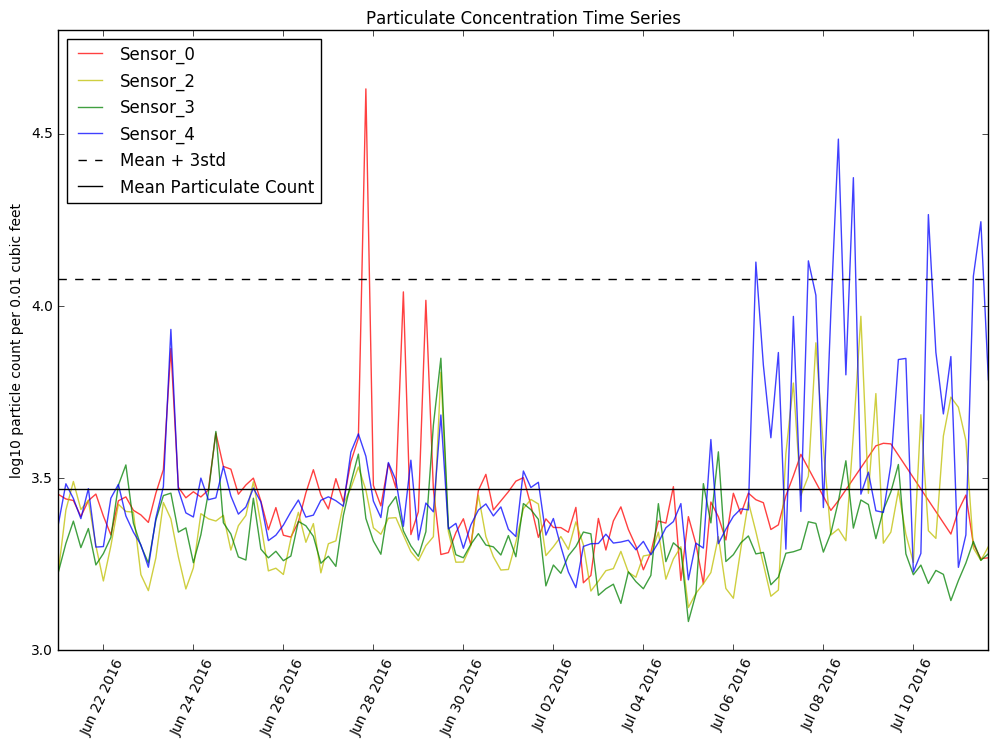

In [6]:
pl.figure(figsize=(12, 8))
pl.plot((redhook[(redhook['sensor']=='sensor_0')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_0')])['con']), 'r', 
       label='Sensor_0', alpha=0.75)
pl.plot((redhook[(redhook['sensor']=='sensor_2')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_2')])['con']), 'y', 
       label='Sensor_2', alpha=0.75)
pl.plot((redhook[(redhook['sensor']=='sensor_3')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_3')])['con']), 'g', 
       label='Sensor_3', alpha=0.75)
pl.plot((redhook[(redhook['sensor']=='sensor_4')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_4')])['con']), 'b', 
       label='Sensor_4', alpha=0.75)
pl.plot((min(redhook['dt']), max(redhook['dt'])), (np.log10(thresh_max), np.log10(thresh_max)), '--', color='k', 
       label='Mean + 3std')
#pl.plot((min(redhook['dt']), max(redhook['dt'])), (np.log10(thresh_min), np.log10(thresh_min)), '--', color='k')
pl.plot((min(redhook['dt']), max(redhook['dt'])), (np.log10(mean_con), np.log10(mean_con)), color='k', 
        label='Mean Particulate Count')
pl.xticks(rotation='65')
pl.legend(loc='best')
pl.title('Particulate Concentration Time Series')
pl.ylabel('log10 particle count per 0.01 cubic feet')

In [7]:
print redhook[((redhook['con'] > thresh_max) & (redhook['sensor'] == 'sensor_0'))] 

print redhook[((redhook['con'] > thresh_max) & (redhook['sensor'] == 'sensor_4'))]

                     dt    sensor   lux        con        spl
164 2016-06-27 20:00:00  sensor_0  44.0  42612.265  76.766054
                     dt    sensor        lux          con        spl
375 2016-07-06 12:00:00  sensor_4  28119.750  13388.50000  73.386988
402 2016-07-07 16:00:00  sensor_4  14136.125  13499.98500  75.079934
416 2016-07-08 08:00:00  sensor_4  15045.750  30462.65750  72.394911
422 2016-07-08 16:00:00  sensor_4   9701.250  23540.73000  80.936906
455 2016-07-10 08:00:00  sensor_4  37156.500  18395.09500  70.323045
477 2016-07-11 08:00:00  sensor_4  18965.500  12186.73375  74.689087
481 2016-07-11 12:00:00  sensor_4  24739.125  17538.62250  73.268664


### Sensors 0 and 4, both of which are placed on rooftops, show spikes of particulate concentration, albeit on different days. Sensor 0, which is placed at an 8 meter elevation on the Red Hook Initiative's roof, spiked well above the mean plus 3 standard deviations threshold on June 27th at 8pm. Sensor 4, which is at an elevation of approximately 15 meters on the roof of PioneerWorks spiked three times at 8am, and twice each at noon and 4pm between July 6th and 11th (excluding July 9th).

In [8]:
thresh_max2 = (np.nanmean(redhook['spl'])) + (3 * np.nanstd(redhook['spl']))
thresh_min2 = (np.nanmean(redhook['spl'])) - (3 * np.nanstd(redhook['spl']))
mean_spl = np.nanmean(redhook['spl'])

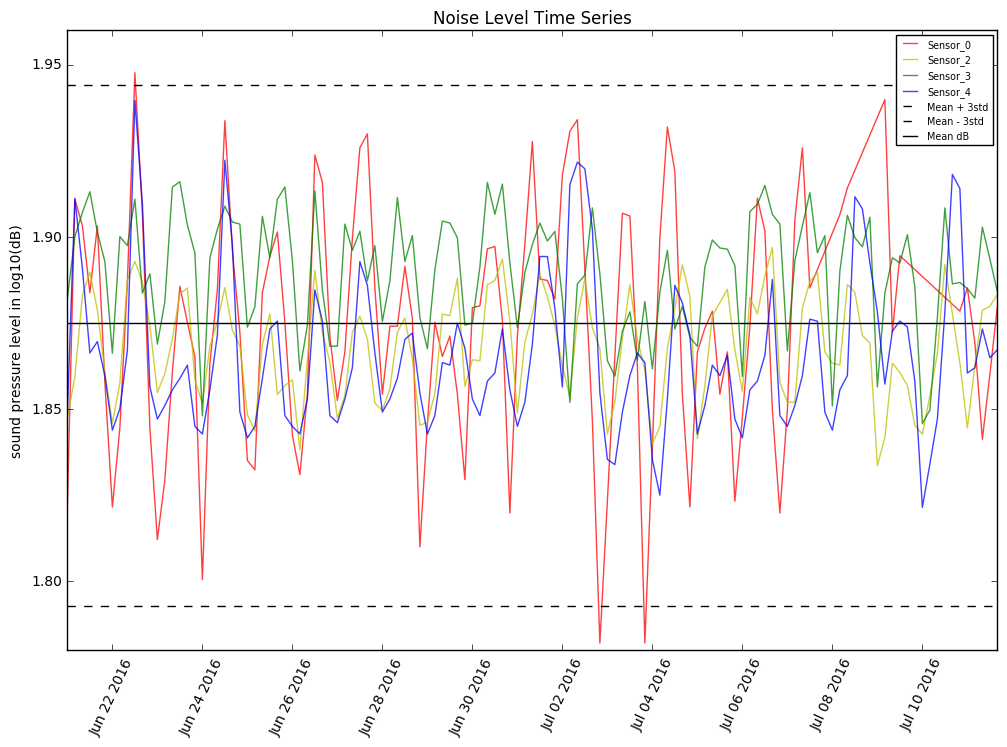

In [9]:
pl.figure(figsize=(12, 8))
pl.plot((redhook[(redhook['sensor']=='sensor_0')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_0')])['spl']), 'r', 
       label='Sensor_0', alpha=0.75)
pl.plot((redhook[(redhook['sensor']=='sensor_2')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_2')])['spl']), 'y', 
       label='Sensor_2', alpha=0.75)
pl.plot((redhook[(redhook['sensor']=='sensor_3')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_3')])['spl']), 'g', 
       label='Sensor_3', alpha=0.75)
pl.plot((redhook[(redhook['sensor']=='sensor_4')])['dt'], np.log10((redhook[(redhook['sensor']=='sensor_4')])['spl']), 'b', 
       label='Sensor_4', alpha=0.75)
pl.plot((min(redhook['dt']), max(redhook['dt'])), (np.log10(thresh_max2), np.log10(thresh_max2)), '--', color='k', 
       label='Mean + 3std')
pl.plot((min(redhook['dt']), max(redhook['dt'])), (np.log10(thresh_min2), np.log10(thresh_min2)), '--', color='k', 
       label='Mean - 3std')
pl.plot((min(redhook['dt']), max(redhook['dt'])), (np.log10(mean_spl), np.log10(mean_spl)), color='k', 
        label='Mean dB')
pl.xticks(rotation='65')
pl.legend(loc='best', fontsize='x-small')
pl.title('Noise Level Time Series')
pl.ylabel('sound pressure level in log10(dB)')

In [10]:
print redhook[((redhook['spl'] > thresh_max2) & (redhook['sensor'] == 'sensor_0'))]
print redhook[((redhook['spl'] < thresh_min2) & (redhook['sensor'] == 'sensor_0'))] 

                    dt    sensor        lux         con        spl
36 2016-06-22 12:00:00  sensor_0  44426.625  2786.37125  88.647875
                     dt    sensor      lux         con        spl
284 2016-07-02 20:00:00  sensor_0  106.000  1647.84875  60.547179
308 2016-07-03 20:00:00  sensor_0  100.875  2005.82750  60.547179


In [11]:
# 311 Complaints from https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9
# Filtered for Noise complaints between June 21, 2016 and July 12, 2016
noise = pd.read_csv('311_Noise.csv')
print noise.columns

Index([u'Unique Key', u'Created Date', u'Closed Date', u'Agency',
       u'Agency Name', u'Complaint Type', u'Descriptor', u'Location Type',
       u'Incident Zip', u'Incident Address', u'Street Name', u'Cross Street 1',
       u'Cross Street 2', u'Intersection Street 1', u'Intersection Street 2',
       u'Address Type', u'City', u'Landmark', u'Facility Type', u'Status',
       u'Due Date', u'Resolution Description',
       u'Resolution Action Updated Date', u'Community Board', u'Borough',
       u'X Coordinate (State Plane)', u'Y Coordinate (State Plane)',
       u'Park Facility Name', u'Park Borough', u'School Name',
       u'School Number', u'School Region', u'School Code',
       u'School Phone Number', u'School Address', u'School City',
       u'School State', u'School Zip', u'School Not Found',
       u'School or Citywide Complaint', u'Vehicle Type',
       u'Taxi Company Borough', u'Taxi Pick Up Location',
       u'Bridge Highway Name', u'Bridge Highway Direction', u'Road Ramp',

In [12]:
noise = noise[['Created Date', 'Closed Date', 'Descriptor', 'Incident Zip']]
noise.head()

,Created Date,Closed Date,Descriptor,Incident Zip
0,06/21/2016 07:42:00 AM,06/21/2016 12:07:00 PM,"Noise, Barking Dog (NR5)",11355.0
1,06/21/2016 11:13:00 PM,06/23/2016 10:00:00 PM,Noise: Construction Before/After Hours (NM1),10010.0
2,06/21/2016 05:17:00 PM,06/22/2016 12:09:00 PM,"Noise, Barking Dog (NR5)",10012.0
3,06/21/2016 11:24:00 AM,06/25/2016 12:00:00 PM,Noise: Construction Before/After Hours (NM1),11365.0
4,06/21/2016 02:57:00 PM,06/22/2016 04:00:00 PM,"Noise, Ice Cream Truck (NR4)",11385.0


In [13]:
print type(noise['Created Date'][1]), type(noise['Incident Zip'][1])

<type 'str'> <type 'numpy.float64'>


In [14]:
noise['Created Date'] = pd.to_datetime(noise['Created Date'], errors="coerce", yearfirst=True)
noise['Closed Date'] = pd.to_datetime(noise['Closed Date'], errors="coerce", yearfirst=True)
print type(noise['Created Date'][1]), type(noise['Created Date'][1])
noise.rename(columns={'Created Date':'Created', 'Closed Date':'Closed', 'Incident Zip':'Zip'}, inplace=True)
noise.head()

<class 'pandas.tslib.Timestamp'> <class 'pandas.tslib.Timestamp'>


,Created,Closed,Descriptor,Zip
0,2016-06-21 07:42:00,2016-06-21 12:07:00,"Noise, Barking Dog (NR5)",11355.0
1,2016-06-21 23:13:00,2016-06-23 22:00:00,Noise: Construction Before/After Hours (NM1),10010.0
2,2016-06-21 17:17:00,2016-06-22 12:09:00,"Noise, Barking Dog (NR5)",10012.0
3,2016-06-21 11:24:00,2016-06-25 12:00:00,Noise: Construction Before/After Hours (NM1),11365.0
4,2016-06-21 14:57:00,2016-06-22 16:00:00,"Noise, Ice Cream Truck (NR4)",11385.0


In [15]:
print len(noise)
noise = noise[(noise['Zip'] == 11231)]
print len(noise)
noise.head()

3245
39


,Created,Closed,Descriptor,Zip
127,2016-06-21 13:39:00,2016-06-29 16:15:00,Noise: Alarms (NR3),11231.0
415,2016-06-23 04:59:00,2016-06-24 07:00:00,Noise: Construction Before/After Hours (NM1),11231.0
427,2016-06-23 20:38:00,2016-06-27 12:02:00,"Noise, Barking Dog (NR5)",11231.0
600,2016-06-24 21:02:00,2016-06-28 21:45:00,Noise: Construction Before/After Hours (NM1),11231.0
636,2016-06-25 10:07:00,2016-07-02 13:15:00,Noise: Jack Hammering (NC2),11231.0


In [16]:
noise.reset_index(drop=True, inplace=True)
#noise.set_index('Created', inplace = True)
noise.head()

,Created,Closed,Descriptor,Zip
0,2016-06-21 13:39:00,2016-06-29 16:15:00,Noise: Alarms (NR3),11231.0
1,2016-06-23 04:59:00,2016-06-24 07:00:00,Noise: Construction Before/After Hours (NM1),11231.0
2,2016-06-23 20:38:00,2016-06-27 12:02:00,"Noise, Barking Dog (NR5)",11231.0
3,2016-06-24 21:02:00,2016-06-28 21:45:00,Noise: Construction Before/After Hours (NM1),11231.0
4,2016-06-25 10:07:00,2016-07-02 13:15:00,Noise: Jack Hammering (NC2),11231.0


In [18]:
noise_hour = noise.Created.groupby([noise.Created.dt.date]).count()
noise_hour

Created
2016-06-21    1
2016-06-23    2
2016-06-24    1
2016-06-25    6
2016-06-26    1
2016-06-27    1
2016-06-28    2
2016-06-29    1
2016-06-30    1
2016-07-01    1
2016-07-02    4
2016-07-03    3
2016-07-04    1
2016-07-05    3
2016-07-06    1
2016-07-07    1
2016-07-08    2
2016-07-09    3
2016-07-10    1
2016-07-11    3
Name: Created, dtype: int64

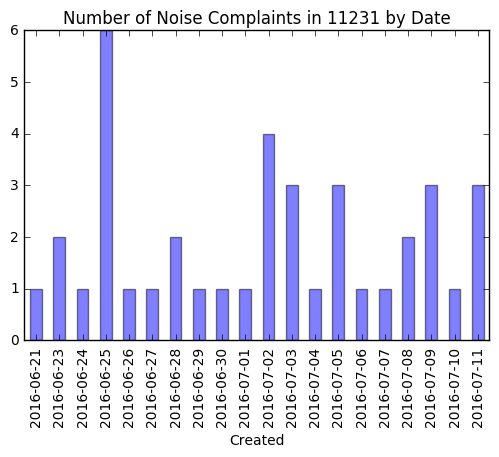

In [19]:
ax = ((noise_hour)).plot(kind="bar", alpha=0.5)
ax.set_title('Number of Noise Complaints in 11231 by Date')

In [24]:
print mean_spl, np.nanstd(redhook['spl'])

74.9948312894 4.31440775059


In [26]:
(redhook[((redhook['dt'] >= '2016-06-25 00:00:00') & (redhook['dt'] < '2016-06-26 00:00:00'))]).spl.mean()

74.336722239987495

## The time series showed a spike over the mean+3std threshold for noise level on June 22nd, however, there were no noise complaints to 311 on that day in the zip code where the sensors are located. On the other hand, the most noise complaints for this three week period were received on June 25th, but the average noise level across all four sensors throughout the day was just over half a dB below the overall mean.

In [27]:
# Weather data from http://forecast.weather.gov/product.php?site=CRH&issuedby=NYC&product=CF6&format=CI&version=12&glossary=1
weather = pd.read_excel("NYCweather.xlsx")
weather

,Date,HighTemp,LowTemp,Precip,AvgWND,Fog,Haze
0,2016-06-21,87,72,NaN,4.8,NaN,1.0
1,2016-06-22,86,68,0.00,4.1,NaN,NaN
2,2016-06-23,83,69,0.00,1.9,NaN,NaN
3,2016-06-24,84,67,0.00,6.2,NaN,1.0
4,2016-06-25,86,64,0.00,3.5,NaN,NaN
5,2016-06-26,87,67,0.00,2.5,NaN,NaN
6,2016-06-27,83,67,0.45,4.9,1.0,NaN
7,2016-06-28,76,68,0.12,3.6,1.0,1.0
8,2016-06-29,83,67,0.01,2.3,1.0,NaN
9,2016-06-30,85,67,0.00,2.8,NaN,NaN


In [28]:
weather['Date'] = pd.to_datetime(weather['Date'], errors="coerce", yearfirst=True)

In [30]:
type(weather.Date[1])

pandas.tslib.Timestamp